In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pickle

from utils import *
from plot_functions import bland_altman_plot, plot_data

2023-10-12 14:36:13.724348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Experiment Parameters

In [2]:
# Set cardiac out (CO) as the prediction variable
prediction_variable = 'CO'
variable_unit = 'L/min'
input_set = 'radial' 

# Define the prediction model
model_selection = 'ANN'

# Enable normalization 
norm_mode = False 

# Enable noise addition and select random noise range
noise_mode = False
noise_perc_lower = 5
noise_perc_upper = 5

# Enable figure saving
save_figure_boolean = False 
experiment_type = 'insilico_{}_{}_{}'.format(input_set,norm_mode, noise_mode)    # Set the type of data being used in the analysis

# Load & Prepare Data

In [3]:
dataset = select_input_dataset(norm_mode)
print('The dataset size is:',dataset.shape)

noisy_dataset = add_random_noise(dataset, noise_perc_lower, noise_perc_upper, noise_mode)
scaled_dataset = scale_data(noisy_dataset)
# print(scaled_dataset.isnull().values.any())

The dataset size is: (3818, 152)
No noise added.


# Regression analysis

In [4]:
# get_and_save_train_test_val_indices(scaled_dataset,select_test_size = 0.2,select_val_rel_size = 0.25) # only the first time

X_train,X_test,X_val,y_train,y_test,y_val = split_train_test_val_sets(scaled_dataset)
print('The size of the train set is:', X_train.shape)
print('The size of the validation set is:', X_val.shape)
print('The size of the test set is:', X_test.shape)

The size of the train set is: (2290, 151)
The size of the validation set is: (764, 151)
The size of the test set is: (764, 151)


### Find Optimal Number of Epochs using Early Stopping Callback

In [5]:
batch_size = 64; verbose = 0; 
# optimal_no_epochs = find_optimal_no_epochs(batch_size,dataset,X_train,X_val,y_train,y_val,prediction_variable,verbose,norm_mode)

# Alternatively, insert values manually
optimal_no_epochs = 61

In [6]:
model, y_pred = artificial_neural_network(batch_size,optimal_no_epochs,X_train,X_test,y_train,y_test,0) 

rescaled_y_test = rescale_values(y_test, prediction_variable, dataset)
rescaled_y_pred = rescale_values(y_pred, prediction_variable, dataset).flatten()


2023-10-12 14:36:22.241741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


24/24 [==============================] - 0s 2ms/step


### Print Results

In [7]:
print_results(rescaled_y_test,rescaled_y_pred,variable_unit)

Mean Absolute Error: 0.2 L/min
Mean Squared Error: 0.09 L/min
Root Mean Squared Error: 0.29 L/min
Normalized Root Mean Squared Error: 4.38 %

Correlation: 0.97
Slope: 1.0
Intercept: -0.02 L/min
r_value: 0.97
p_value: 0.0
Distribution of the reference data: 6.0 ± 1.2 L/min
Distribution of the predicted data: 5.9 ± 1.3 L/min


### Plot Results

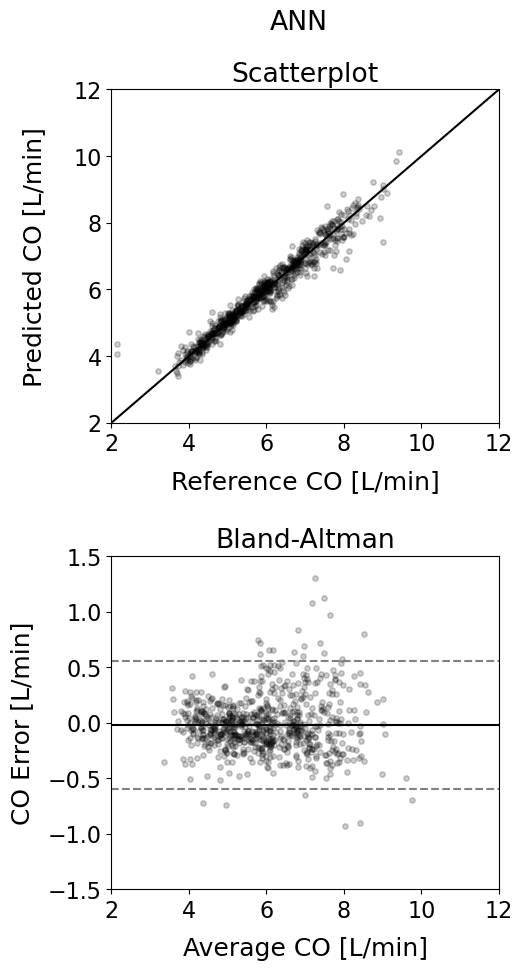

Bias: -0.02 L/min
Upper LoA: 0.56 L/min
Lower LoA: -0.59 L/min


In [8]:
plot_data(rescaled_y_test,rescaled_y_pred,experiment_type,prediction_variable,model_selection,save_figure_boolean)

# Run experiments using the saved models

In [9]:
# Load pre-developed models from disk
if norm_mode:
    loaded_model = pickle.load(open('uncal_data_trained_model.sav', 'rb'))
else:
    loaded_model = pickle.load(open('cal_data_trained_model.sav', 'rb'))
        
loaded_model.fit(X_test, y_test)
y_pred = loaded_model.predict(X_test)

rescaled_y_test = rescale_values(y_test, prediction_variable, dataset)
rescaled_y_pred = rescale_values(y_pred, prediction_variable, dataset).flatten()
    
print_results(rescaled_y_test,rescaled_y_pred,variable_unit)

24/24 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.31 L/min
Mean Squared Error: 0.16 L/min
Root Mean Squared Error: 0.4 L/min
Normalized Root Mean Squared Error: 5.99 %

Correlation: 0.97
Slope: 0.93
Intercept: 0.67 L/min
r_value: 0.97
p_value: 0.0
Distribution of the reference data: 6.0 ± 1.2 L/min
Distribution of the predicted data: 6.2 ± 1.2 L/min
